In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, plot_roc_curve, \
                            plot_precision_recall_curve, precision_recall_curve, \
                            f1_score, make_scorer
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [93]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip

In [94]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.drop(columns=['duration'], axis=1, inplace=True)
df.loc[df['y']=='yes', ['y']] = 1
df.loc[df['y']=='no', ['y']] = 0
df['y'] = df['y'].astype('int')
x = df.drop(columns=['y'], axis=1)
y = df['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=66)

categorical = ['job', 'marital', 'education', 'default','housing','loan','contact',\
               'month','day_of_week','poutcome']
numerical = ['age', 'campaign', 'pdays', 'previous','emp.var.rate','cons.price.idx',\
               'cons.conf.idx','euribor3m','nr.employed']


In [95]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [96]:
# df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
# df.drop(columns=['duration'], axis=1, inplace=True)

# #dropping not obvious features
# df.drop(columns=['contact', 'month', 'day_of_week', 'pdays', 'previous', 'poutcome',\
#                 'campaign', 'emp.var.rate','cons.price.idx',\
#                'cons.conf.idx','euribor3m','nr.employed'], 
#         axis=1, inplace=True)

# df.loc[df['y']=='yes', ['y']] = 0
# df.loc[df['y']=='no', ['y']] = 1
# df['y'] = df['y'].astype('int')
# x = df.drop(columns=['y'], axis=1)
# y = df['y']
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)

# categorical = ['job', 'marital', 'education', 'default','housing','loan','contact',\
#                'month','day_of_week','poutcome']
# numerical = ['age', 'campaign', 'pdays', 'previous','emp.var.rate','cons.price.idx',\
#                'cons.conf.idx','euribor3m','nr.employed']


/home/constantine/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1_score:  0.3652822151224707
CPU times: user 1.31 s, sys: 27.8 ms, total: 1.33 s
Wall time: 726 ms


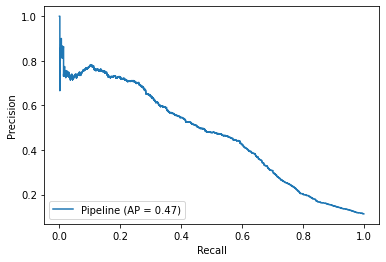

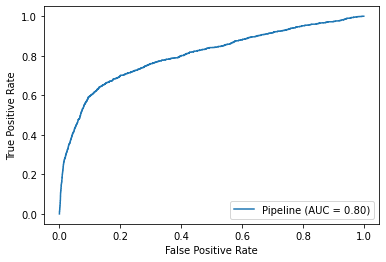

In [97]:
%%time
transformer_ohe = ColumnTransformer(transformers=[
                                            ('polynom', PolynomialFeatures(degree=2), ['age']),
                                            ('num', StandardScaler(), numerical),
                                          ('cat', OneHotEncoder(), categorical)])
pipeline_ohe = Pipeline(steps=[('transformer', transformer_ohe),
                              ('class', LogisticRegression())])
pipeline_ohe.fit(x_train, y_train)
prediction_ohe = pipeline_ohe.predict(x_test)

plot_precision_recall_curve (pipeline_ohe, x_test, y_test)
plot_roc_curve (pipeline_ohe, x_test, y_test)

y_test_array = y_test.array

print('f1_score: ', f1_score(y_test_array, prediction_ohe))

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin

class CounterEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, target, this=True):
        self.target = target
        self.this = this
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        that = self.this
        df_copy = x.copy()
        df_copy['y'] = self.target
        
        for column in categorical:
            column_name = column + '_counter'
            
            for value in pd.unique(df_copy[column]):

                number_of_obj = df_copy.loc[df_copy[column] == value, [column]].shape[0]
                sum_of_target = df_copy.loc[df_copy[column] == value, ['y']].sum()[0]

#                 print({'column': column, 'value': value, 
#                        'number_of_obj': number_of_obj, 'sum_of_target': sum_of_target})

                df_copy.loc[df_copy[column] == value, [column_name]] = sum_of_target / number_of_obj
            
            noise_amplitude = 0.02
            column_len = df_copy[column_name].shape[0]
            df_copy[column_name] += np.random.uniform(-noise_amplitude, noise_amplitude, column_len)

            df_copy.drop(columns=[column], axis=1, inplace=True)
        df_copy.drop(columns=['y'], axis=1, inplace=True)
        return df_copy

pipeline_counter = Pipeline(steps=[('counter', CounterEncoder(target=y_train))])
pipeline_counter.fit_transform(X=x_train)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_counter,marital_counter,education_counter,default_counter,housing_counter,loan_counter,contact_counter,month_counter,day_of_week_counter,poutcome_counter
12446,37,4,999,0,1.4,93.918,-42.7,4.960,5228.1,0.076925,0.107680,0.096793,0.124397,0.097018,0.102427,0.159107,0.105463,0.115643,0.082133
37039,27,1,999,0,-2.9,92.469,-33.6,1.044,5076.2,0.125993,0.128722,0.151116,0.120971,0.096598,0.112879,0.139279,0.076515,0.133826,0.088746
24374,31,2,999,0,-0.1,93.200,-42.0,4.191,5195.8,0.066947,0.093424,0.078680,0.115171,0.124258,0.129609,0.148190,0.096586,0.097357,0.106908
9019,37,2,999,0,1.4,94.465,-41.8,4.866,5228.1,0.084388,0.107508,0.060905,0.126431,0.123197,0.112122,0.059862,0.099493,0.131352,0.098348
23605,32,2,999,0,1.4,93.444,-36.1,4.962,5228.1,0.124789,0.106914,0.139300,0.109924,0.090721,0.110354,0.134139,0.121413,0.105034,0.099585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31381,35,1,999,0,-1.8,92.893,-46.2,1.334,5099.1,0.087457,0.094065,0.070902,0.057867,0.104129,0.116586,0.144263,0.062324,0.104905,0.071914
5199,53,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.099757,0.089090,0.119510,0.128384,0.101193,0.124961,0.062384,0.059829,0.098631,0.087228
8243,50,2,999,0,1.4,94.465,-41.8,4.864,5228.1,0.077882,0.093765,0.061422,0.048127,0.102168,0.098130,0.038905,0.089456,0.133176,0.097971
8823,52,1,999,0,1.4,94.465,-41.8,4.866,5228.1,0.091517,0.086365,0.111281,0.032566,0.106787,0.112539,0.071734,0.112692,0.120127,0.095661


f1_score:  0.3154929577464789
CPU times: user 2.56 s, sys: 51.9 ms, total: 2.61 s
Wall time: 1.95 s


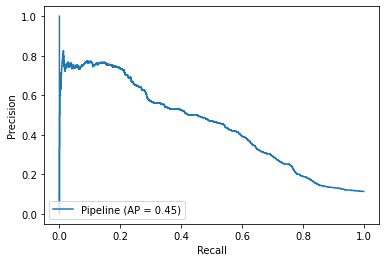

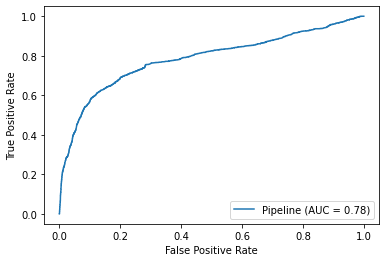

In [99]:
%%time
transformer_counter = ColumnTransformer(transformers=[('num', StandardScaler(), numerical)])
pipeline_counter = Pipeline(steps=[('counter', CounterEncoder(y_train)),\
                                   ('transformer', transformer_counter),
                              ('class', LogisticRegression(max_iter=100000))])

pipeline_counter.fit(x_train, y_train)
prediction_counter = pipeline_counter.predict(x_test)

plot_precision_recall_curve (pipeline_counter, x_test, y_test)
plot_roc_curve (pipeline_counter, x_test, y_test)

y_test_array = y_test.array
print('f1_score: ', f1_score(y_test_array, prediction_counter))

In [100]:
def profit_scorer_func (y_truth, y_pred):
    df = pd.DataFrame(data={'y_truth': y_truth, 'y_pred': y_pred})
    to_call = df.loc[df['y_pred']==1]
    num_of_call = to_call.shape[0]
    income_per_client = np.random.uniform(0, 20, len(y_truth))
    income = np.dot(income_per_client, y_truth)
    costs = 1 * num_of_call
    return income - costs
                            
profit_scorer_func(y_test, prediction_ohe)

13501.753495364737

In [101]:
profit_scorer = make_scorer(score_func=profit_scorer_func, greater_is_better=True)

In [102]:
searcher = GridSearchCV(pipeline_ohe, param_grid={'class__C': np.logspace(-4, 1, 10)},\
                        cv=3, scoring=profit_scorer)
searcher.fit(x_train, y_train)
print(searcher.best_score_)
print(searcher.best_params_)

/home/constantine/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/constantine/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/constantine/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/constantine/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

10814.132983026944
{'class__C': 0.0001}
